# Imports and Drive mount

In [1]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [52]:
import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F
import torchmetrics
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

In [3]:
# Google Drive will get mounted automatically
# Then, cd into that directory
%cd /content/drive/MyDrive/1s2/Deep Learning/Deep Project/checkpoints

/content/drive/MyDrive/1s2/Deep Learning/Deep Project/checkpoints


In [4]:
#@title Checkpoints filename
teacher_model_checkpoint_filename = './256-sigmoid-big.pt'
student_model_trained_encoder_checkpoint_filename = 'student_model_trained_encoder.pt'
student_model_trained_enc_dec_checkpoint_filename = 'student_model_trained_enc_dec.pt'
student_model_trained_full_checkpoint_filename = 'student_model_trained_full.pt'
alone_student_model_checkpoint_filename = 'alone_student_model.pt'
e2e_student_model_checkpoint_filename = 'e2e_student_model.pt'

In [5]:
#@title Utility functions
def print_params(model: nn.Module):
    print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
    print('Frozen parameters:', sum(p.numel() for p in model.parameters() if not p.requires_grad))
    print('Parameters type:', model.parameters().__next__().dtype)
    print('Parameters device:', model.parameters().__next__().device)
    print()


# Function to initialize the weights of our network
def weights_init(m):
    className = m.__class__.__name__
    if className.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", className)


def print_outputs(outputs):
  if type(outputs) is list or type(outputs) is tuple:
    for i in outputs:
      print_outputs(i)
  elif type(outputs) is torch.Tensor:
    print(outputs.dtype, outputs.shape)
  else:
    print(outputs)


def plot_losses_history(losses_history):
  train_losses, test_losses = zip(*losses_history)

  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Test Losses')
  plt.show()


def show_image(image, title=None):
  image = image.cpu()

  if len(image.shape) == 4:
    image = image.squeeze()

  plt.imshow(image, cmap='gray')

  if title is not None:
    plt.title(title)

  plt.axis('off')


def show_images(images):
  plt.figure()
  for i, image in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    if type(image) is tuple:
      image, title = image
      show_image(image, title)
    else:
      show_image(image)
  plt.show()


def test_model(encoder_model, decoder_model, embeddings_model=None):
  if embeddings_model is None:
    embeddings_model = teacher_vq_vae

  # Pick a random image from MNIST dataset
  input_image, _ = testset[3]
  input_image = input_image[None, ...].to(device)
  input_image.dtype, input_image.shape

  print('Using encoder:', encoder_model.__class__.__name__)
  print('Using decoder:', decoder_model.__class__.__name__)

  with torch.no_grad():
    teacher_x_tilde, _, _ = teacher_vq_vae(input_image)

    z_e_x = encoder_model.encoder(input_image)
    codes = embeddings_model.codeBook(z_e_x)
    latents = embeddings_model.codes_to_latents(codes)
    student_x_tilde = decoder_model.decode_latents(latents)

  show_images([
      (input_image, 'Original image'),
      (teacher_x_tilde, 'Teacher model'),
      (student_x_tilde, 'Student model'),
  ])

  teacher_student_image_l2 = F.mse_loss(teacher_x_tilde, student_x_tilde)
  print(f'L2 distance between teacher and student reconstructions: {teacher_student_image_l2:.4f}')

# Define teacher model

In [6]:
# finding the z_e_q given x (by comparing with z_e_x)
class VectorQuantization(Function):

    @staticmethod
    def forward(ctx, inputs, codeBook):
        with torch.no_grad():
            # assigning the dimension of our embedding
            embedding_size = codeBook.size(1)

            inputs_size = inputs.size()
            # Flatten input
            inputs_flatten = inputs.view(-1, embedding_size)

            codeBook_sqr = torch.sum(codeBook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances of the inputs to the codeBook
            distances = torch.addmm(codeBook_sqr + inputs_sqr,
                                    inputs_flatten, codeBook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
                           '`VectorQuantization`. The function `VectorQuantization` '
                           'is not differentiable. Use `VectorQuantizationStraightThrough` '
                           'if you want a straight-through estimator of the gradient.')


# Required to pass gradients received by z_e_q to z_e_x as torch.min function makes the back-propagation gradient
# impossible
class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codeBook):

        # evaluating the indices with the least distance between inputs and codeBook
        indices = vq(inputs, codeBook)
        indices_flatten = indices.view(-1)
        # saving indices for backward pass
        ctx.save_for_backward(indices_flatten, codeBook)
        ctx.mark_non_differentiable(indices_flatten)
        codes_flatten = torch.index_select(codeBook, dim=0,
                                           index=indices_flatten)
        # get embedding corresponding to the inputs
        codes = codes_flatten.view_as(inputs)

        return codes, indices_flatten

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codeBook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient with respect to the codeBook
            indices, codeBook = ctx.saved_tensors
            embedding_size = codeBook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                   .view(-1, embedding_size))

            # for passing gradient backwards
            grad_codeBook = torch.zeros_like(codeBook)
            grad_codeBook.index_add_(0, indices, grad_output_flatten)

        return grad_inputs, grad_codeBook


vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply

In [7]:
# Structure of the residual block

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

In [8]:
# Structure of the embedding layer
class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        # creating the embedding
        self.embedding = nn.Embedding(K, D)
        # weights belong to a uniform distribution
        self.embedding.weight.data.uniform_(-1. / K, 1. / K)

    # z_e_x --> latent code for the input image
    def forward(self, z_e_x):
        # converting BCHW --> BHWC
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        # Retrieving the indices corresponding to the input
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    # z_e_x --> latent code for the input image
    def straight_through(self, z_e_x):
        # converting BCHW --> BHWC
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()

        # z_q_x --> latent code from the embedding nearest to the input code
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        # z_q_x_bar --> backprop possible
        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
                                               dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        # used for generating the image (decoding)
        return z_q_x, z_q_x_bar

In [9]:
# Architecture of VQ-VAE
class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codeBook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Sigmoid()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        codes = self.codeBook(z_e_x)
        return codes

    def decode(self, codes):
        z_q_x = self.codeBook.embedding(codes).permute(0, 3, 1, 2)  # (B, C, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def codes_to_latents(self,codes):
        return self.codeBook.embedding(codes).permute(0, 3, 1, 2)  # (B, C, H, W)

    def decode_latents(self, z_q_x):
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codeBook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

In [10]:
# Parameters from EvaluateSeparationConfig.vqvae
input_dim, dim, K, device = 1, 128, 256, "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)

teacher_vq_vae = VectorQuantizedVAE(input_dim, dim, K).to(device)
with open(teacher_model_checkpoint_filename, 'rb') as f:
        teacher_vq_vae.load_state_dict(torch.load(f, map_location=device))

print_params(teacher_vq_vae)

Using device: cuda
Trainable parameters: 1220481
Frozen parameters: 0
Parameters type: torch.float32
Parameters device: cuda:0



# Define a smaller student model
It still has to follow a similar architecture as the teacher model,
but drastically reducing the number of parameters involved.

In [11]:
class DistilResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),  # Since it is a resblock, dimensionality of the output of self.block MUST be the same as the input X
            nn.BatchNorm2d(dim),
            # nn.LeakyReLU(),
            # nn.Conv2d(dim, dim, 1),
            # nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

In [12]:
class DistilVectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, _dim, K=512):
        super().__init__()

        kernel_size, stride, padding = 6, 4, 1  # Match the output size 28x28

        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, kernel_size, stride, padding),
            nn.BatchNorm2d(dim),
            nn.LeakyReLU(),

            # Use only 1 ResBlock instead of 2
            DistilResBlock(dim),
        )

        # Still, keep K the same (determining the output shape)
        self.codeBook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            # Use only 1 ResBlock instead of 2
            DistilResBlock(dim),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(dim, input_dim, kernel_size, stride, padding),
            nn.Sigmoid()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        codes = self.codeBook(z_e_x)
        return codes

    def decode(self, codes):
        z_q_x = self.codeBook.embedding(codes).permute(0, 3, 1, 2)  # (B, C, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def codes_to_latents(self,codes):
        return self.codeBook.embedding(codes).permute(0, 3, 1, 2)  # (B, C, H, W)

    def decode_latents(self, z_q_x):
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codeBook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

In [ ]:
student_model = DistilVectorQuantizedVAE(input_dim, dim, K).to(device)
print_params(student_model)

Trainable parameters: 338049
Frozen parameters: 0
Parameters type: torch.float32
Parameters device: cuda:0



In [ ]:
student_model

DistilVectorQuantizedVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): DistilResBlock(
      (block): Sequential(
        (0): LeakyReLU(negative_slope=0.01)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (codeBook): VQEmbedding(
    (embedding): Embedding(256, 128)
  )
  (decoder): Sequential(
    (0): DistilResBlock(
      (block): Sequential(
        (0): LeakyReLU(negative_slope=0.01)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 1, kern

In [ ]:
teacher_vq_vae

VectorQuantizedVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResBlock(
      (block): Sequential(
        (0): LeakyReLU(negative_slope=0.01)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): ResBlock(
      (block): Sequential(
        (0): LeakyReLU(negative_slope=0.01)
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNo

## Check the output size of the 2 models
They must match, so that we can enforce the outputs logits similarity in the loss function

In [ ]:
# Do some sanity checks on the outputs dimensionality
x = torch.rand((1, 1, 28, 28)).to(device)

z_e_x = student_model.encoder(x)
assert z_e_x.shape == (1, 128, 7, 7), f'Expected (1, 128, 7, 7), got {z_e_x.shape}'

codes = student_model.codeBook(z_e_x)
assert codes.shape == (1, 7, 7), f'Expected (1, 7, 7), got {codes.shape}'

z_q_x = student_model.codeBook.embedding(codes).permute(0, 3, 1, 2)  # (B, C, H, W)
assert z_q_x.shape == (1, 128, 7, 7), f'Expected (1, 128, 7, 7), got {z_q_x.shape}'

x_tilde = student_model.decoder(z_q_x)
assert x_tilde.shape == (1, 1, 28, 28), f'Expected (1, 1, 28, 28), got {x_tilde.shape}'

In [ ]:
teacher_model_params_no = sum(p.numel() for p in teacher_vq_vae.parameters())
student_model_params_no = sum(p.numel() for p in student_model.parameters())
f'Parameters reduced of approx. {(teacher_model_params_no - student_model_params_no)/teacher_model_params_no*100:.0f}%'

'Parameters reduced of approx. 72%'

In [ ]:
min_latent_code, max_latent_code = codes.min(), codes.max()
assert min_latent_code >= 0, f'Expected min_latent_code >= 0, got {min_latent_code}'
assert max_latent_code <= 255, f'Expected max_latent_code <= 255, got {max_latent_code}'
f'For this random input batch, latent codes go from {min_latent_code.item()} to {max_latent_code.item()}. They are the indexes for the Embedding codebook!'

'For this random input batch, latent codes go from 4 to 253. They are the indexes for the Embedding codebook!'

## Next steps overview (Student Encoder)
Train the student model on the MNIST dataset, with a loss function that aims to minimize the L2-distance between the float32 logits of the teacher model, before the codebook.

We decided not to add to the loss also the reconstruction loss: we just want to mimic the teacher model's latent code, which is what LASS is built upon.

To train the student, use the same parameters as the teacher:
- batch_size: 64
- lr: 1e-4
- torchvision.datasets.MNIST(train=True)

Parameters obtained from *configs/vqvae_training/mnist.yaml*

Understand `P` training code [here](https://github.com/simonesestito/latent-autoregressive-source-separation/blob/main/lass_mnist/lass/train_sums.py#L24)
    
    Images mixture: torch.Size([32, 1, 28, 28])
    Z_e_x1: torch.Size([32, 128, 7, 7])
    Z_e_x2: torch.Size([32, 128, 7, 7])
    Z_e_x_mixture: torch.Size([32, 128, 7, 7])
    Codes1: torch.Size([32, 7, 7])
    Codes2: torch.Size([32, 7, 7])
    Codes mixture: torch.Size([32, 7, 7])
    Codes1: torch.Size([1568])
    Codes2: torch.Size([1568])
    Codes mixture: torch.Size([1568])
    Sums: torch.Size([256, 256, 256])

In [ ]:
sums = torch.rand((256, 256, 256))
codes1 = torch.randint(0, 100, (1568,), dtype=torch.int64)
codes2 = torch.randint_like(codes1, 0, 100)
codes_mix = torch.randint_like(codes1, 0, 100)

print_outputs(sums[codes1, codes2, codes_mix])  # Pick indexes [i, j, k] for i, j, k in zip(codes1, codes2, codes_mix)

torch.float32 torch.Size([1568])


In [13]:
#@title Add Early Stopping in training
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
#@title Training parameters

batch_size = 64
num_epochs = 50  # Instead of 500
lr = 1e-4

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

!mkdir -p /content/mnist/data

trainset = torchvision.datasets.MNIST(root='/content/mnist/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='/content/mnist/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4314910.45it/s]


Extracting /content/mnist/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/mnist/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 55428.26it/s]


Extracting /content/mnist/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/mnist/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 271966.89it/s]


Extracting /content/mnist/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/mnist/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10297583.12it/s]


Extracting /content/mnist/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/mnist/data/MNIST/raw



In [ ]:
#@title Student model training loop
student_model = DistilVectorQuantizedVAE(input_dim, dim, K).to(device)

# Train the student model, but freeze the teacher model
student_model.train()
teacher_vq_vae.eval()

optimizer = torch.optim.Adam(student_model.encoder.parameters(), lr=lr)
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

losses_history = []


def loop_forward_pass(inputs_batch):
  inputs_batch = inputs_batch.to(device)

  with torch.no_grad():
    teacher_z_e_x_mixture = teacher_vq_vae.encoder(inputs_batch)
  assert teacher_z_e_x_mixture.grad is None

  student_z_e_x_mixture = student_model.encoder(inputs_batch)

  # Calculate the loss as stated before
  return F.mse_loss(student_z_e_x_mixture, teacher_z_e_x_mixture)


for epoch in tqdm(range(num_epochs), file=sys.stdout):
  train_loss, test_loss = 0.0, 0.0

  # Training loop
  for i, (inputs_batch, _) in enumerate(trainloader):
    # Calculate the loss as stated before
    loss = loop_forward_pass(inputs_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(trainloader)

  # Measure how's going with test data
  with torch.no_grad():
    for i, (inputs_batch, _) in enumerate(testloader):
      test_loss += loop_forward_pass(inputs_batch).item()

  test_loss /= len(testloader)

  losses_history.append((train_loss, test_loss))

  print(f'\rEpoch {epoch + 1}, Training Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}', flush=True)

  # Early stopping
  if early_stopper.early_stop(test_loss):
    print("Early stopping triggered")
    break

print('Finished Training')

Epoch 1, Training Loss: 0.36399, Test Loss: 0.25525
Epoch 2, Training Loss: 0.20685, Test Loss: 0.16399
Epoch 3, Training Loss: 0.12410, Test Loss: 0.09769
Epoch 4, Training Loss: 0.08233, Test Loss: 0.07473
Epoch 5, Training Loss: 0.06613, Test Loss: 0.06296
Epoch 6, Training Loss: 0.05604, Test Loss: 0.05430
Epoch 7, Training Loss: 0.04792, Test Loss: 0.04721
Epoch 8, Training Loss: 0.04169, Test Loss: 0.04206
Epoch 9, Training Loss: 0.03759, Test Loss: 0.03917
Epoch 10, Training Loss: 0.03555, Test Loss: 0.03782
Epoch 11, Training Loss: 0.03436, Test Loss: 0.03685
Epoch 12, Training Loss: 0.03351, Test Loss: 0.03614
Epoch 13, Training Loss: 0.03305, Test Loss: 0.03599
Epoch 14, Training Loss: 0.03272, Test Loss: 0.03565
Epoch 15, Training Loss: 0.03250, Test Loss: 0.03547
Epoch 16, Training Loss: 0.03232, Test Loss: 0.03540
Epoch 17, Training Loss: 0.03218, Test Loss: 0.03532
Epoch 18, Training Loss: 0.03200, Test Loss: 0.03497
Epoch 19, Training Loss: 0.03191, Test Loss: 0.03490
Ep

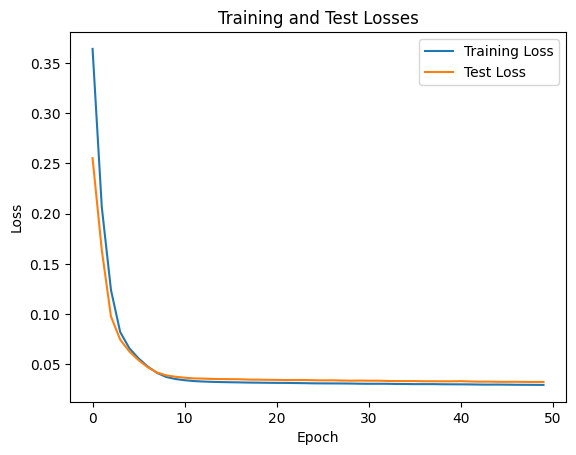

In [ ]:
plot_losses_history(losses_history)

In [ ]:
torch.save(student_model.state_dict(), student_model_trained_encoder_checkpoint_filename)

## Test the reconstruction replacing only the Encoder
Reconstruct the image using the teacher pre-trained model, but with the student Encoder

Using encoder: DistilVectorQuantizedVAE
Using decoder: VectorQuantizedVAE


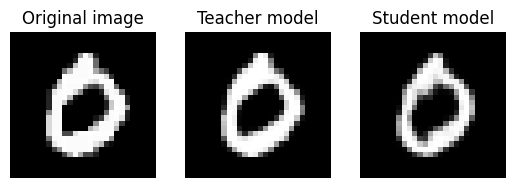

L2 distance between teacher and student reconstructions: 0.0094


In [ ]:
test_model(encoder_model=student_model, decoder_model=teacher_vq_vae)

## Train the student decoder
Repeat what we did with the Encoder, this time with the Decoder.

For now, the codebook will stay the same

In [ ]:
# Restore the saved model
student_model = DistilVectorQuantizedVAE(input_dim, dim, K).to(device)
with open(student_model_trained_encoder_checkpoint_filename, 'rb') as f:
  student_model.load_state_dict(torch.load(f, map_location=device))
student_model.train()
teacher_vq_vae.eval()

student_model.decoder.apply(weights_init)

optimizer = torch.optim.Adam(student_model.decoder.parameters(), lr=lr)
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

losses_history = []


def loop_forward_pass(inputs_batch):
  inputs_batch = inputs_batch.to(device)

  with torch.no_grad():
    z_e_x = teacher_vq_vae.encoder(inputs_batch)
    codes = teacher_vq_vae.codeBook(z_e_x)
    latents = teacher_vq_vae.codes_to_latents(codes)
    teacher_x_tilde = teacher_vq_vae.decode_latents(latents)

  student_x_tilde = student_model.decoder(latents)

  # Calculate the loss on the reconstructed image
  return F.mse_loss(student_x_tilde, teacher_x_tilde)


for epoch in tqdm(range(num_epochs), file=sys.stdout):
  train_loss, test_loss = 0.0, 0.0

  # Training loop
  for i, (inputs_batch, _) in enumerate(trainloader):
    # Calculate the loss as stated before
    loss = loop_forward_pass(inputs_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(trainloader)

  # Measure how's going with test data
  with torch.no_grad():
    for i, (inputs_batch, _) in enumerate(testloader):
      test_loss += loop_forward_pass(inputs_batch).item()

  test_loss /= len(testloader)

  losses_history.append((train_loss, test_loss))

  print(f'\rEpoch {epoch + 1}, Training Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}', flush=True)

  # Early stopping
  if early_stopper.early_stop(test_loss):
    print("Early stopping triggered")
    break

print('Finished Training')

Epoch 1, Training Loss: 0.03794, Test Loss: 0.01076
Epoch 2, Training Loss: 0.00742, Test Loss: 0.00539
Epoch 3, Training Loss: 0.00443, Test Loss: 0.00375
Epoch 4, Training Loss: 0.00330, Test Loss: 0.00301
Epoch 5, Training Loss: 0.00273, Test Loss: 0.00259
Epoch 6, Training Loss: 0.00239, Test Loss: 0.00233
Epoch 7, Training Loss: 0.00217, Test Loss: 0.00219
Epoch 8, Training Loss: 0.00201, Test Loss: 0.00202
Epoch 9, Training Loss: 0.00190, Test Loss: 0.00194
Epoch 10, Training Loss: 0.00181, Test Loss: 0.00187
Epoch 11, Training Loss: 0.00174, Test Loss: 0.00179
Epoch 12, Training Loss: 0.00170, Test Loss: 0.00174
Epoch 13, Training Loss: 0.00166, Test Loss: 0.00173
Epoch 14, Training Loss: 0.00162, Test Loss: 0.00166
Epoch 15, Training Loss: 0.00158, Test Loss: 0.00163
Epoch 16, Training Loss: 0.00156, Test Loss: 0.00160
Epoch 17, Training Loss: 0.00154, Test Loss: 0.00157
Epoch 18, Training Loss: 0.00152, Test Loss: 0.00156
Epoch 19, Training Loss: 0.00150, Test Loss: 0.00154
Ep

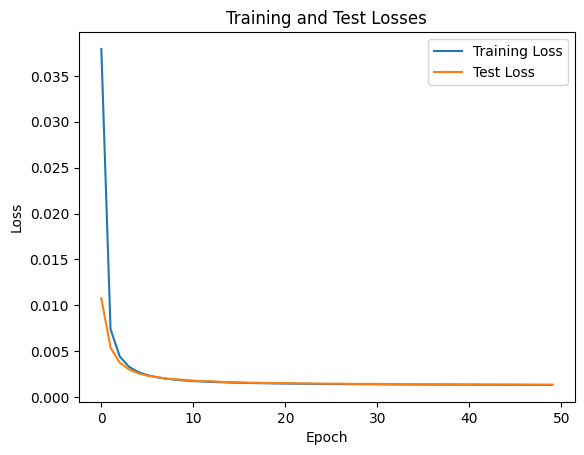

In [ ]:
plot_losses_history(losses_history)

In [ ]:
torch.save(student_model.state_dict(), student_model_trained_enc_dec_checkpoint_filename)

## Test both encoder and decoder from the Student model


Using encoder: DistilVectorQuantizedVAE
Using decoder: DistilVectorQuantizedVAE


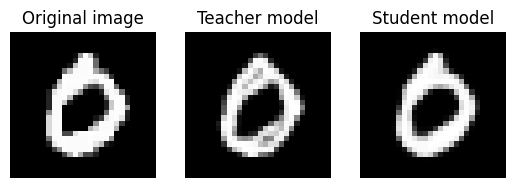

L2 distance between teacher and student reconstructions: 0.0088


In [ ]:
test_model(encoder_model=student_model, decoder_model=student_model)

## Benchmark the performance improvement

In [ ]:
benchmark_batch_size = 128  #@param{type: 'integer', min: 1}
benchmark_device = 'cpu'

print('Benchmark on', benchmark_device)
print('Using', benchmark_batch_size, 'items')

# Load test images
input_images = testset.data[:benchmark_batch_size]
input_images = input_images.unsqueeze(1).float() / 255.0
input_images = input_images.to(benchmark_device)
print(input_images.dtype, input_images.shape, input_images.device)

# Run the benchmark!
@torch.no_grad()
def _benchmark_model(model, measure_end_to_end=False):
  z_e_x = model.encoder(input_images)
  # Always use the teacher model for the codebook
  codes = teacher_vq_vae.codeBook(z_e_x)
  latents = teacher_vq_vae.codes_to_latents(codes)
  student_x_tilde = model.decode_latents(latents)
  return student_x_tilde[0, 0, 0, 0]

# Move the models on the CPU
student_model = student_model.to(benchmark_device)
teacher_vq_vae = teacher_vq_vae.to(benchmark_device)

Benchmark on cpu
Using 128 items
torch.float32 torch.Size([128, 1, 28, 28]) cpu


In [ ]:
print('Benchmark of teacher encoder only')
%timeit _benchmark_model(teacher_vq_vae, measure_end_to_end=False)

Benchmark of teacher encoder only
323 ms ± 9.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print('Benchmark of student encoder only')
%timeit _benchmark_model(student_model, measure_end_to_end=False)

Benchmark of student encoder only
86.3 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
print('Benchmark of teacher VQ-VAE end-to-end')
%timeit _benchmark_model(teacher_vq_vae, measure_end_to_end=True)

Benchmark of teacher VQ-VAE end-to-end
309 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print('Benchmark of student VQ-VAE end-to-end, using the teacher decoder')
%timeit _benchmark_model(student_model, measure_end_to_end=True)

Benchmark of student VQ-VAE end-to-end, using the teacher decoder
93.3 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Restore everything on the standard device (presumably a CUDA GPU)
student_model = student_model.to(device)
teacher_vq_vae = teacher_vq_vae.to(device)

It reduced:
- parameters by **72%**
- execution time by **67%** (from $\approx$ 300 ms to $\approx$ 100 ms)

**Tested on CPU**, with a batch, to have a stronger difference in execution time

## Save the full Student model
Copy the Teacher's embedding codebook

In [ ]:
student_model.codeBook = teacher_vq_vae.codeBook

torch.save(student_model.state_dict(), student_model_trained_full_checkpoint_filename)

# Train Student model alone
With no teacher available, and see its performance.

It is the training of a standalone VQ-VAE.

The **loss** is *NOT ONLY* the reconstruction loss, but it is actually composed of three components:
1. reconstruction loss
2. codebook loss
3. commitment loss

More resources on how to train a VQ-VAE: [here](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb) and [here](https://github.com/Vrushank264/VQVAE-PyTorch/blob/main/train.py)

In [17]:
#@title VQ-VAE loss
def compute_vqvae_loss(model, input_batch, beta):
  input_batch = input_batch.to(device)

  x_tilde, z_e_x, z_q_x = model(input_batch)

  # The final loss is composed of 3 components:
  # 1. reconstruction loss
  recon_loss = F.mse_loss(x_tilde, input_batch)
  # 2. codebook loss
  codebook_loss = F.mse_loss(z_q_x, z_e_x.detach())
  # 3. commitment loss
  commitment_loss = F.mse_loss(z_e_x, z_q_x.detach())

  return recon_loss + codebook_loss + beta * commitment_loss

In [15]:
beta = 0.25  #@param {type: 'number', min:0.01, max:1.0}

In [ ]:
#@title Training loop
alone_student_model = DistilVectorQuantizedVAE(input_dim, dim, K).to(device)

# Train the student model, but freeze the teacher model
alone_student_model.train()

optimizer = torch.optim.Adam(alone_student_model.parameters(), lr=lr)
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

losses_history = []


for epoch in tqdm(range(num_epochs), file=sys.stdout):
  train_loss, test_loss = 0.0, 0.0

  # Training loop
  for i, (inputs_batch, _) in enumerate(trainloader):
    # Calculate the loss as stated before
    loss = compute_vqvae_loss(alone_student_model, inputs_batch, beta)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(trainloader)

  # Measure how's going with test data
  with torch.no_grad():
    for i, (inputs_batch, _) in enumerate(testloader):
      test_loss += compute_vqvae_loss(alone_student_model, inputs_batch, beta).item

  test_loss /= len(testloader)

  losses_history.append((train_loss, test_loss))

  print(f'\rEpoch {epoch + 1}, Training Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}', flush=True)

  # Early stopping
  if early_stopper.early_stop(test_loss):
    print("Early stopping triggered")
    break

print('Finished Training')

Epoch 1, Training Loss: 1.80600, Test Loss: 1.34923
Epoch 2, Training Loss: 1.12076, Test Loss: 0.92376
Epoch 3, Training Loss: 0.74811, Test Loss: 0.57507
Epoch 4, Training Loss: 0.45351, Test Loss: 0.35577
Epoch 5, Training Loss: 0.28728, Test Loss: 0.23746
Epoch 6, Training Loss: 0.19786, Test Loss: 0.16822
Epoch 7, Training Loss: 0.14494, Test Loss: 0.12597
Epoch 8, Training Loss: 0.11291, Test Loss: 0.10197
Epoch 9, Training Loss: 0.09288, Test Loss: 0.08504
Epoch 10, Training Loss: 0.07693, Test Loss: 0.07033
Epoch 11, Training Loss: 0.06513, Test Loss: 0.06186
Epoch 12, Training Loss: 0.05642, Test Loss: 0.05318
Epoch 13, Training Loss: 0.04966, Test Loss: 0.04851
Epoch 14, Training Loss: 0.04483, Test Loss: 0.04402
Epoch 15, Training Loss: 0.04146, Test Loss: 0.04136
Epoch 16, Training Loss: 0.03876, Test Loss: 0.03901
Epoch 17, Training Loss: 0.03650, Test Loss: 0.03664
Epoch 18, Training Loss: 0.03474, Test Loss: 0.03542
Epoch 19, Training Loss: 0.03348, Test Loss: 0.03444
Ep

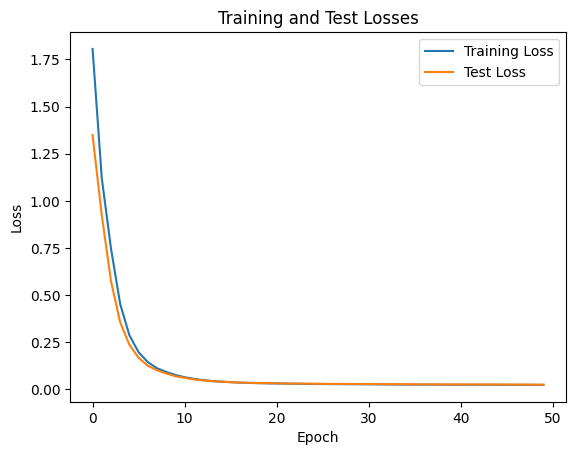

In [ ]:
plot_losses_history(losses_history)

In [ ]:
torch.save(alone_student_model.state_dict(), alone_student_model_checkpoint_filename)

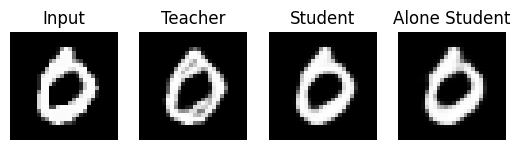

In [ ]:
#@title Show an example from this alone student

# Pick a random image from MNIST dataset
input_image, _ = testset[3]
input_image = input_image[None, ...].to(device)
input_image.dtype, input_image.shape

with torch.no_grad():
  alone_x_tilde, _, _ = alone_student_model(input_image)
  student_x_tilde, _, _ = student_model(input_image)
  teacher_x_tilde, _, _ = teacher_vq_vae(input_image)

show_images([
    (input_image, 'Input'),
    (teacher_x_tilde, 'Teacher'),
    (student_x_tilde, 'Student'),
    (alone_x_tilde, 'Alone Student'),
])

# End-to-End Student
Train the student model end-to-end, as the alone student, but freeze the embeddings

In [40]:
#@title Training loop
e2e_student_model = DistilVectorQuantizedVAE(input_dim, dim, K).to(device)
e2e_student_model.train()

optimizer = torch.optim.Adam(e2e_student_model.parameters(), lr=lr)
early_stopper = EarlyStopper(patience=3, min_delta=0.005)

losses_history = []

# Use teacher codeBook
e2e_student_model.codeBook.load_state_dict(teacher_vq_vae.codeBook.state_dict())
for p in e2e_student_model.codeBook.parameters():
  p.requires_grad = False


for epoch in tqdm(range(num_epochs), file=sys.stdout):
  train_loss, test_loss = 0.0, 0.0

  # Training loop
  for i, (inputs_batch, _) in enumerate(trainloader):
    # Calculate the loss as stated before
    loss = compute_vqvae_loss(e2e_student_model, inputs_batch, beta)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(trainloader)

  # Measure how's going with test data
  with torch.no_grad():
    for i, (inputs_batch, _) in enumerate(testloader):
      test_loss += compute_vqvae_loss(e2e_student_model, inputs_batch, beta).item()

  test_loss /= len(testloader)

  losses_history.append((train_loss, test_loss))

  print(f'\rEpoch {epoch + 1}, Training Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}', flush=True)

  # Early stopping
  if early_stopper.early_stop(test_loss):
    print("Early stopping triggered")
    break

print('Finished Training')

Epoch 1, Training Loss: 0.58710, Test Loss: 0.50054
Epoch 2, Training Loss: 0.58412, Test Loss: 0.66199
Epoch 3, Training Loss: 0.72075, Test Loss: 0.78347
Epoch 4, Training Loss: 0.81791, Test Loss: 0.85778
Early stopping triggered
  6%|▌         | 3/50 [00:52<13:35, 17.35s/it]
Finished Training


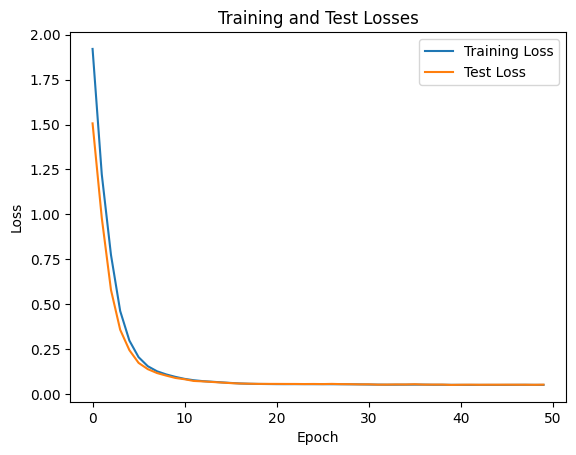

In [28]:
plot_losses_history(losses_history)

In [29]:
torch.save(e2e_student_model.state_dict(), e2e_student_model_checkpoint_filename)

# Testing
We want to test all models on some metrics, on the whole dataset, and not just a simple visual example as in the cells so far.

In [47]:
#@title Reload all saved models
def load_eval_model(filename) -> nn.Module:
  model_class = VectorQuantizedVAE \
      if filename == teacher_model_checkpoint_filename \
      else DistilVectorQuantizedVAE

  model = model_class(input_dim, dim, K).to(device)
  with open(filename, 'rb') as f:
    model.load_state_dict(torch.load(f, map_location=device))

  model.eval()

  # Freeze parameters
  for param in model.parameters():
    param.requires_grad = False

  # A small check, just to be sure
  assert not model.encoder.parameters().__next__().requires_grad
  assert not model.decoder.parameters().__next__().requires_grad
  assert not model.codeBook.parameters().__next__().requires_grad

  return model


teacher_model = load_eval_model(teacher_model_checkpoint_filename)
student_model = load_eval_model(student_model_trained_full_checkpoint_filename)
alone_student_model = load_eval_model(alone_student_model_checkpoint_filename)
e2e_student_model = load_eval_model(e2e_student_model_checkpoint_filename)

## Reconstruction Loss
Measure how good these models reconstruct the original image.

In [53]:
@torch.no_grad()
def measure_reconstruction(model, dataloader):
  model = model.to(device)

  def _compute_metrics(inputs_batch, reconstructed_batch, old_metrics=None):
    # Use both L2 and PSNR, from the original LASS paper
    new_l2 = F.mse_loss(inputs_batch, reconstructed_batch).item()

    dims = list(range(1, len(inputs_batch.shape)))  # First dimension is Batch
    new_psnr = torchmetrics.functional.peak_signal_noise_ratio(
        inputs_batch,
        reconstructed_batch,
        dim=dims,
        data_range=1.0,
    ).item()

    if old_metrics is not None:
      old_l2, old_psnr = old_metrics['l2'], old_metrics['psnr']
      new_l2, new_psnr = 0.5 * old_l2 + 0.5 * new_l2, 0.5 * old_psnr + 0.5 * new_psnr

    return {
        'l2': new_l2,
        'psnr': new_psnr,
    }


  input_metrics, teacher_metrics = None, None

  for i, (inputs_batch, _) in enumerate(dataloader):
    inputs_batch = inputs_batch.to(device)

    # Reconstruct the image
    reconstructed_batch, _, _ = model(inputs_batch)
    input_metrics = _compute_metrics(inputs_batch, reconstructed_batch, old_metrics=input_metrics)

    if type(model) == DistilVectorQuantizedVAE:
      # Also compare with teacher's output
      teacher_batch, _, _ = teacher_model(inputs_batch)
      teacher_metrics = _compute_metrics(teacher_batch, reconstructed_batch, old_metrics=teacher_metrics)


  # Format metrics
  def _format_metrics(metrics):
    if metrics is None:
      return metrics
    return { k: f'{v:.4f}' for k, v in metrics.items() }

  return _format_metrics(input_metrics), _format_metrics(teacher_metrics)

Remember that:
- L2 = lower is better
- PSNR = higher is better

In [54]:
models = [
    (teacher_model, 'Teacher'),
    (student_model, 'Student Enc-Dec'),
    (alone_student_model, 'Alone Student'),
    (e2e_student_model, 'E2E Student'),
]

for model, model_name in models:
  # Measure on training data
  train_input_metrics, train_teacher_metrics = measure_reconstruction(model, trainloader)
  # Measure on testing data
  test_input_metrics, test_teacher_metrics = measure_reconstruction(model, testloader)

  print(model_name)
  print('\tOn training data:')
  print(f'\t\tOn input:', train_input_metrics)
  print(f'\t\tOn teacher:', train_teacher_metrics)
  print('\tOn testing data:')
  print(f'\t\tOn input:', test_input_metrics)
  print(f'\t\tOn teacher:', test_teacher_metrics)
  print()

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


Teacher
	On training data:
		On input: {'l2': '0.0012', 'psnr': '29.8255'}
		On teacher: None
	On testing data:
		On input: {'l2': '0.0015', 'psnr': '29.1254'}
		On teacher: None

Student Enc-Dec
	On training data:
		On input: {'l2': '0.0047', 'psnr': '23.9728'}
		On teacher: {'l2': '0.0041', 'psnr': '24.6110'}
	On testing data:
		On input: {'l2': '0.0041', 'psnr': '24.5385'}
		On teacher: {'l2': '0.0037', 'psnr': '25.1832'}

Alone Student
	On training data:
		On input: {'l2': '0.0039', 'psnr': '24.4886'}
		On teacher: {'l2': '0.0036', 'psnr': '24.7860'}
	On testing data:
		On input: {'l2': '0.0038', 'psnr': '24.7428'}
		On teacher: {'l2': '0.0037', 'psnr': '24.8593'}

E2E Student
	On training data:
		On input: {'l2': '0.0042', 'psnr': '24.2214'}
		On teacher: {'l2': '0.0040', 'psnr': '24.5008'}
	On testing data:
		On input: {'l2': '0.0044', 'psnr': '24.0527'}
		On teacher: {'l2': '0.0041', 'psnr': '24.3795'}



We can observe that:
1. The Teacher model is still, by far, the best one among all of them
2. The Student Enc-Dec model performs better than the "alone student" when compared to the teacher's output, but a little worse on reconstructing the input
3. The e2e student works worse than the others; we also observe that, on the contrary of the other 2 students, it has better scores on training data than on test ones.

Purely on input data reconstruction, the alone student performed better

## LASS performance
Measure how well these models perform in the context of the LASS task, and not simply as autoencoders.

In [ ]:
# Clone the repository
%cd /content/
!rm -rf /content/latent-autoregressive-source-separation
!git clone https://github.com/simonesestito/latent-autoregressive-source-separation.git

# Copy the models checkpoints
%cd /content/latent-autoregressive-source-separation/lass_mnist/checkpoints/
!tar -xvf '/content/drive/MyDrive/1s2/Deep Learning/Deep Project/lass-mnist-ckpts.tar'
!cp '/content/drive/MyDrive/1s2/Deep Learning/Deep Project/checkpoints/student_model_trained_full.pt' ./vqvae/

# CD into main project directory
%cd /content/latent-autoregressive-source-separation/lass_mnist/

/content
Cloning into 'latent-autoregressive-source-separation'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (374/374), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 374 (delta 69), reused 346 (delta 45), pack-reused 0
Receiving objects: 100% (374/374), 540.71 KiB | 12.57 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/content/latent-autoregressive-source-separation/lass_mnist/checkpoints
./sum/256-sigmoid-big.pt
./unconditioned/256-sigmoid-big.pt
./vqvae/256-sigmoid-big.pt
/content/latent-autoregressive-source-separation/lass_mnist


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install -e /content/latent-autoregressive-source-separation/diba

Obtaining file:///content/latent-autoregressive-source-separation/diba
  Preparing metadata (setup.py) ... done
  Running setup.py develop for diba


We still have to **re-train likelihood**, or a specific Code may be unknown

Example of error:
```
Traceback (most recent call last):
  File "/content/latent-autoregressive-source-separation/lass_mnist/lass/separate.py", line 288, in main
    (gen1, gen2), (gen1lat, gen2lat) = generate_samples(
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/latent-autoregressive-source-separation/lass_mnist/lass/separate.py", line 114, in generate_samples
    r0, r1 = separation_method(
  File "/content/latent-autoregressive-source-separation/diba/diba/diba.py", line 169, in separate
    result = sep_model.generate(
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py", line 1288, in generate
    return self.greedy_search(
  File "/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py", line 1683, in greedy_search
    outputs = self(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/content/latent-autoregressive-source-separation/diba/diba/diba.py", line 116, in forward
    raise RuntimeError(f"Code {self.mixture[self.sample_t]} is not available in likelihood!")
RuntimeError: Code 83 is not available in likelihood!
```

Code that raised the exception:
```python
# compute log posterior
if ll_coords.numel() == 0:
    raise RuntimeError(f"Code {self.mixture[self.sample_t]} is not available in likelihood!")
```

In [ ]:
!PYTHONPATH=. python lass/train_sums.py

2024-08-03 13:58:55.929826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 13:58:55.949952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 13:58:55.956095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 13:58:55.971226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 13:58:57.076116: W tensorflow/comp

In [ ]:
!cp models/sums-MNIST/best.pt checkpoints/sum/256-sigmoid-big.pt
!cp models/sums-MNIST/best.pt '/content/drive/MyDrive/1s2/Deep Learning/Deep Project/checkpoints/new_sum_256-sigmoid-big.pt'

In [ ]:
!PYTHONPATH=. python lass/separate.py